In [1]:
import xarray as xr
import pathlib
import pop_tools
import pooch
import gsw
import numpy as np
import dask.array as da

In [2]:
polygon_id = '000'
intervention_month = '01'
region = 'North_Atlantic_basin'
original_polygon_id = 0
data_dir = pathlib.Path('/pscratch/sd/a/abanihi/dor/fg-co2-excess/')

In [3]:
one_polygon_single_season_path = data_dir / f'{polygon_id}-{intervention_month}.zarr'
one_polygon_single_season_path

PosixPath('/pscratch/sd/a/abanihi/dor/fg-co2-excess/000-01.zarr')

In [4]:
ds = xr.open_dataset(one_polygon_single_season_path, engine='zarr', decode_timedelta=False)
ds

<xarray.Dataset> Size: 110MB
Dimensions:                 (nlat: 384, nlon: 320, polygon_id: 1,
                             intervention_date: 1, elapsed_time: 180)
Coordinates: (12/57)
    ANGLE                   (nlat, nlon) float64 983kB ...
    ANGLET                  (nlat, nlon) float64 983kB ...
    DXT                     (nlat, nlon) float64 983kB ...
    DXU                     (nlat, nlon) float64 983kB ...
    DYT                     (nlat, nlon) float64 983kB ...
    DYU                     (nlat, nlon) float64 983kB ...
    ...                      ...
    sea_ice_salinity        float64 8B ...
    sflux_factor            float64 8B ...
    sound                   float64 8B ...
    stefan_boltzmann        float64 8B ...
    time_delta              float64 8B ...
    vonkar                  float64 8B ...
Dimensions without coordinates: nlat, nlon
Data variables:
    FG_CO2_excess           (polygon_id, intervention_date, elapsed_time, nlat, nlon) float32 88MB ...
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    history:           none
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    start_time:        This dataset was created on 2024-11-04 at 21:08:03.3
    time_period_freq:  month_1
    title:             smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_19...

In [5]:
grid = pop_tools.get_grid('POP_gx1v7')
file_paths = pooch.retrieve(
    url="https://storage.googleapis.com/oae-dor-global-efficiency-mtyka/data.zip",
    known_hash="md5:4251a7b2bf023c282bccce6cdef976d7",
    processor=pooch.Unzip(members=['data/polygon_data/Pacific_final_cluster_centers.npy', 
                                   'data/polygon_data/Atlantic_final_cluster_centers.npy', 
                                   'data/polygon_data/South_final_cluster_centers_120EEZ_180openocean.npy', 
                                   'data/polygon_data/Southern_Ocean_final_cluster_centers.npy', 
                                   'data/polygon_data/Pacific_final_polygon_mask.npy',
                                   'data/polygon_data/Atlantic_final_polygon_mask.npy',
                                   'data/polygon_data/South_final_polygon_mask_120EEZ_180openocean.npy',
                                   'data/polygon_data/Southern_Ocean_final_polygon_mask.npy'
                                   ])
)

file_paths

['/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/South_final_polygon_mask_120EEZ_180openocean.npy',
 '/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/Atlantic_final_cluster_centers.npy',
 '/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/Pacific_final_cluster_centers.npy',
 '/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/Atlantic_final_polygon_mask.npy',
 '/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/Pacific_final_polygon_mask.npy',
 '/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/Southern_Ocean_final_cluster_centers.npy',
 '/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/South_final_cluster_centers_120EEZ_180openocean.npy'

In [6]:
def load_cluster_centers_and_masks(file_paths):
    """Load cluster centers from files based on region identifiers in file paths."""
    # Define region keys and their file identifiers
    region_identifiers = {
        "North_Atlantic_basin": "Atlantic",
        "North_Pacific_basin": "Pacific_final_cluster_centers",
        "South": "South_final",
        "Southern_Ocean": "Southern_Ocean"
    }
    
    # Initialize dictionary to store cluster centers by region
    cluster_centers = {region: None for region in region_identifiers}
    cluster_masks = {region: None for region in region_identifiers}
    
    # Load cluster centers for each region
    for path in file_paths:
        for region, identifier in region_identifiers.items():
            if 'center' in path and identifier in path:
                cluster_centers[region] = np.load(path, allow_pickle=True)
                break
            elif 'mask' in path and identifier in path:
                cluster_masks[region] = np.load(path, allow_pickle=True)
                break
    
    return cluster_centers, cluster_masks

cluster_centers, cluster_masks = load_cluster_centers_and_masks(file_paths)

In [7]:
def calculate_distance(target, grid):
    tlong = grid.TLONG.values
    tlat = grid.TLAT.values
    n, m = tlong.shape
    distance = np.zeros_like(tlong)
    for idx in range(n):
        for idy in range(m):
            distance[idx, idy] = gsw.distance([tlong[idx,idy], target[0]], [tlat[idx,idy], target[1]])
    return distance

def make_rings(dist, num_rings:int=100):
    """
    Return ring matrix, assign each grid point to a certain ring
    """
    bin_edges = np.arange(0, 4100*1e3, 50*1e3)
    # use digitize to assign each point to a ring
    rings = np.digitize(dist, bin_edges, right=True)
    return bin_edges, rings

In [8]:
centers = cluster_centers[region]
centers.shape

(150, 2)

In [9]:
distances = calculate_distance(centers[original_polygon_id], grid)
distances

/pscratch/sd/a/abanihi/ipykernel_159969/169468976.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distance[idx, idy] = gsw.distance([tlong[idx,idy], target[0]], [tlat[idx,idy], target[1]])


array([[15459541.070673  , 15463116.70239444, 15467041.25947087, ...,
        15450914.38140498, 15453439.31354815, 15456315.06405404],
       [15400763.20875984, 15404474.53977151, 15408548.09039083, ...,
        15391809.31217085, 15394429.98708147, 15397414.81023316],
       [15341972.39136462, 15345816.60499384, 15350036.05633477, ...,
        15332698.07840241, 15335412.50913407, 15338504.14122292],
       ...,
       [ 1377091.74288757,  1385364.36048728,  1394305.97562688, ...,
         1356512.89499249,  1362645.69127487,  1369511.69473692],
       [ 1421629.172033  ,  1428949.88702016,  1436874.42623623, ...,
         1403478.52293601,  1408876.60399791,  1414932.10402076],
       [ 1467061.30118733,  1473463.56855514,  1480404.13341932, ...,
         1451240.79127937,  1455936.0126484 ,  1461213.84446665]])

In [10]:
bin_edges, rings = make_rings(distances)

In [11]:
def compute_cumulative_FG_CO2_ring_dask(dset, polygon_id, intervention_month, bin_edges, rings):
    """Compute cumulative FG CO2 by ring, with Dask support for parallel processing."""
    
    FG_CO2_excess_area_time = (dset.FG_CO2_excess * dset.TAREA * dset.time_delta) / 1e6 * 86400  # mmol
    
    rings_da = da.from_array(rings, chunks=-1)
    
    total_FG_CO2 = FG_CO2_excess_area_time.sum(dim=['elapsed_time', 'nlat', 'nlon'])
    
    num_time = FG_CO2_excess_area_time.sizes['elapsed_time']
    num_rings = len(bin_edges)

    result = []
    
    # Process each ring
    for idx in range(num_rings):
        ring_mask = xr.where(rings_da == idx+1, 1, 0)
        
        # Calculate ring values and store in list
        ring_values = (FG_CO2_excess_area_time * ring_mask).sum(dim=['nlat', 'nlon'])
        result.append(ring_values)
    
    # Combine results along a new dimension
    FG_CO2_rings = xr.concat(result, dim=xr.DataArray(range(num_rings), dims='ring_idx'))
    FG_CO2_rings = FG_CO2_rings.transpose('elapsed_time', 'ring_idx', ...)
    

    FG_CO2_rings_per = FG_CO2_rings / total_FG_CO2
    

    ds = xr.Dataset({
        'FG_CO2_percent': (['intervention_date', 'elapsed_time', 'dist2center'], 
                           FG_CO2_rings_per.data.reshape(1, num_time, num_rings))
    }, coords={
        'intervention_month': [int(intervention_month)],
        'elapsed_time': np.arange(num_time).astype('int32'),
        'dist2center': bin_edges
    })
    

    ds = ds.expand_dims(polygon_id=[polygon_id])
    
    return ds

In [12]:
data = compute_cumulative_FG_CO2_ring_dask(ds, polygon_id, intervention_month, bin_edges, rings)
data

<xarray.Dataset> Size: 119kB
Dimensions:             (polygon_id: 1, intervention_date: 1,
                         elapsed_time: 180, dist2center: 82,
                         intervention_month: 1)
Coordinates:
  * polygon_id          (polygon_id) object 8B '000'
  * intervention_month  (intervention_month) int64 8B 1
  * elapsed_time        (elapsed_time) int32 720B 0 1 2 3 4 ... 176 177 178 179
  * dist2center         (dist2center) float64 656B 0.0 5e+04 ... 4e+06 4.05e+06
Dimensions without coordinates: intervention_date
Data variables:
    FG_CO2_percent      (polygon_id, intervention_date, elapsed_time, dist2center) float64 118kB dask.array<chunksize=(1, 1, 180, 1), meta=np.ndarray>

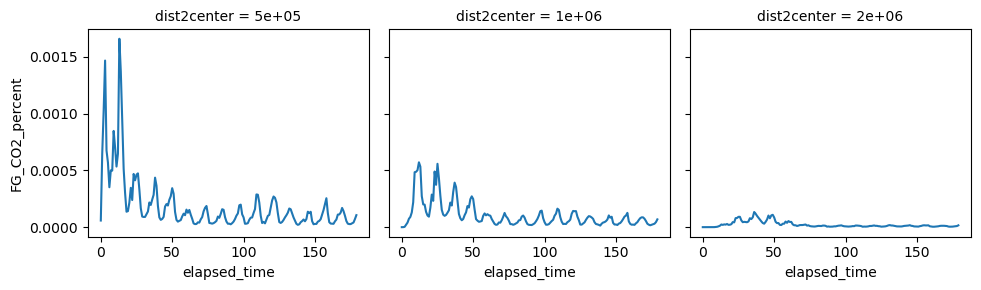

In [13]:
values = np.array([500, 1000, 2000]) * 1_000 # conversion to meters
data.sel(dist2center=values, method='nearest').FG_CO2_percent.plot(col='dist2center')

In [14]:
data.to_netcdf('/pscratch/sd/a/abanihi/000-01-percent.nc', engine='netcdf4')